In [1]:
import os
os.chdir(os.path.join(os.getcwd(),'../..'))

In [29]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2g}'.format)

In [3]:
noisy_analysis_files = [i.replace('.json.gz', '') for i in os.listdir('../dataset/solutions') 
                        if i.startswith('bc_noise#')]

In [4]:
from services import DataReader

X, y = DataReader().read_analyze_solution('bc_averaging_disease_analysis#k=0')

noise_size = [f[11:19] for f in noisy_analysis_files]
noisy_analysis = [DataReader().read_analyze_solution(f)[0] for f in noisy_analysis_files]

noise_size.insert(0, 0)
noisy_analysis.insert(0, X)

In [5]:
from preprocessing import DynamicPreprocessing

X_pathways = list()
X_fs_pathways = list()

for analysis in noisy_analysis:
    pre = DynamicPreprocessing(['flux-diff', 'pathway-scoring', 'transport-elimination'])
    X_pathways.append(pre.fit_transform(analysis, y))

    pre = DynamicPreprocessing(['flux-diff', 'feature-selection', 'pathway-scoring', 'transport-elimination'])
    X_fs_pathways.append(pre.fit_transform(analysis, y))

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
            ('dy', DynamicPreprocessing(['flux-diff', 'feature-selection', 'pathway-scoring', 'transport-elimination'])),
            ('vect', DictVectorizer(sparse=False)),
            ('pca', PCA()),
            ('clf', LogisticRegression(C=0.3e-6, random_state=43))
        ])

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold

scores = list()

for analysis in noisy_analysis:
    kf = StratifiedKFold(n_splits=10, random_state=43)
    kf_scores = cross_val_score(pipe, analysis, y, cv=kf, n_jobs=-1, scoring='f1_micro')
    scores.append(kf_scores.mean())

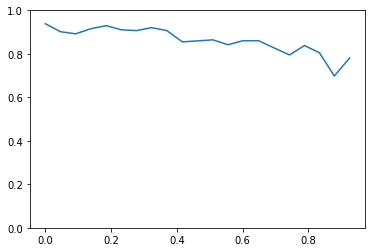

In [8]:
import matplotlib.pyplot as plt
from functional import seq

plt.ylim(0, 1)
backward_error, accuracies = list(zip(*seq(noise_size).map(float).zip(scores).order_by(lambda x: x[0]).to_list()))
plt.plot(backward_error, accuracies)

In [9]:
from noise import NoiseGenerator

relative_noise = lambda data, noisy_data: NoiseGenerator(None, None).relative_noise_size(data, data - noisy_data)

matrix_fs_pathways = [pd.DataFrame.from_records(x).values for x in X_pathways]

forward_error = [relative_noise(matrix_fs_pathways[0], m) for m in matrix_fs_pathways]

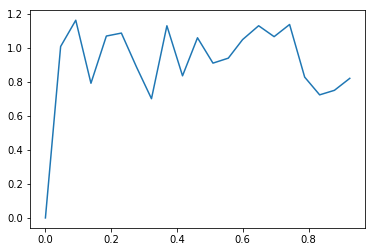

In [10]:
plt.plot(backward_error, forward_error)

In [11]:
df = pd.DataFrame.from_records(X_fs_pathways[0])
df.insert(0, 'labels', y)
df

labels  Alanine and aspartate metabolism_dif  Aminosugar metabolism_dif  \
0       bc                               1.4e+03                   -6.2e+02   
1       bc                               1.4e+03                   -6.2e+02   
2       bc                               1.4e+03                      5e+02   
3       bc                               1.4e+03                   -6.2e+02   
4       bc                               1.4e+03                   -6.2e+02   
5       bc                               1.4e+03                   -6.2e+02   
6       bc                               1.4e+03                   -3.4e+02   
7       bc                               1.4e+03                   -6.2e+02   
8       bc                               1.4e+03                   -6.2e+02   
9       bc                               1.4e+03                   -6.2e+02   
10      bc                               1.4e+03                   -6.2e+02   
11      bc                               1.4e+03                   -6.2e+02   
12      bc                               1.4e+03                   -6.2e+02   
13      bc                               1.4e+03                   -6.2e+02   
14      bc                               1.4e+03                   -6.2e+02   
15      bc                               1.4e+03                   -6.2e+02   
16      bc                               1.4e+03                   -6.2e+02   
17      bc                               1.4e+03                   -6.2e+02   
18      bc                               1.4e+03                   -6.2e+02   
19      bc                               1.4e+03                   -6.2e+02   
20      bc                               1.4e+03                   -6.2e+02   
21      bc                               1.4e+03                   -6.2e+02   
22      bc                               1.4e+03                   -6.2e+02   
23      bc                               1.4e+03                    3.8e+02   
24      bc                               1.4e+03                   -6.2e+02   
25      bc                               1.4e+03                   -6.2e+02   
26      bc                               1.4e+03                   -6.2e+02   
27      bc                               1.4e+03                   -6.2e+02   
28      bc                               1.4e+03                   -6.2e+02   
29      bc                               1.4e+03                   -6.2e+02   
30      bc                               1.4e+03                   -6.2e+02   
31      bc                               1.4e+03                   -6.2e+02   
32      bc                               1.4e+03                   -6.2e+02   
33      bc                               1.4e+03                   -6.2e+02   
34      bc                               1.4e+03                      1e+03   
35       h                                -6e+02                   -6.2e+02   
36       h                                -6e+02                   -6.2e+02   
37       h                                -6e+02                   -6.2e+02   
38       h                                -6e+02                   -6.2e+02   
39       h                                -6e+02                   -6.2e+02   
40       h                                -6e+02                    3.8e+02   
41       h                                -6e+02                    1.4e+03   
42       h                               1.4e+03                   -6.2e+02   
43       h                               1.4e+03                   -6.2e+02   
44       h                                -6e+02                    3.8e+02   
45       h                               1.4e+03                   -3.7e+02   
46       h                                -6e+02                   -6.2e+02   
47       h                                -6e+02                   -6.2e+02   
48       h                                -6e+02                   -6.2e+02   
49       h                               1.4e+03      

In [30]:
df = pd.DataFrame.from_records(X_fs_pathways[1])
df.insert(0, 'labels', y)
df

labels  Alanine and aspartate metabolism_dif  Aminosugar metabolism_dif  \
0       bc                               1.5e+03                   -5.7e+02   
1       bc                               1.5e+03                   -5.7e+02   
2       bc                               1.5e+03                    1.4e+03   
3       bc                               1.5e+03                    4.3e+02   
4       bc                               1.5e+03                   -5.7e+02   
5       bc                               1.5e+03                   -5.7e+02   
6       bc                               1.5e+03                   -5.7e+02   
7       bc                              -5.2e+02                   -5.7e+02   
8       bc                               1.5e+03                    1.9e+02   
9       bc                               1.5e+03                   -5.7e+02   
10      bc                               1.5e+03                   -5.7e+02   
11      bc                               1.5e+03                   -5.7e+02   
12      bc                               1.5e+03                   -5.7e+02   
13      bc                               1.5e+03                   -2.4e+02   
14      bc                               1.5e+03                   -5.7e+02   
15      bc                               1.5e+03                   -5.7e+02   
16      bc                               1.5e+03                   -5.7e+02   
17      bc                               1.5e+03                   -5.7e+02   
18      bc                               1.5e+03                   -5.7e+02   
19      bc                               1.5e+03                   -5.7e+02   
20      bc                               1.5e+03                   -5.7e+02   
21      bc                               1.5e+03                   -5.2e+02   
22      bc                               1.5e+03                   -5.7e+02   
23      bc                               1.5e+03                   -5.7e+02   
24      bc                               1.5e+03                   -3.8e+02   
25      bc                               1.5e+03                    1.4e+03   
26      bc                               1.5e+03                   -5.7e+02   
27      bc                               1.5e+03                   -5.7e+02   
28      bc                               1.5e+03                   -5.7e+02   
29      bc                               1.5e+03                   -4.5e+02   
30      bc                               1.5e+03                   -5.7e+02   
31      bc                               1.5e+03                   -5.7e+02   
32      bc                               1.5e+03                   -5.7e+02   
33      bc                               1.5e+03                   -5.7e+02   
34      bc                               1.5e+03                   -5.7e+02   
35       h                              -5.2e+02                   -5.7e+02   
36       h                              -5.2e+02                   -5.7e+02   
37       h                              -5.2e+02                   -5.7e+02   
38       h                              -5.2e+02                    9.4e+02   
39       h                              -5.2e+02                   -5.7e+02   
40       h                              -5.2e+02                    4.1e+02   
41       h                               1.5e+03                   -5.7e+02   
42       h                               1.5e+03                   -5.7e+02   
43       h                              -5.2e+02                   -5.7e+02   
44       h                              -5.2e+02                    8.3e+02   
45       h                              -5.2e+02                   -3.2e+02   
46       h                              -5.2e+02                   -5.7e+02   
47       h                              -5.2e+02                   -5.7e+02   
48       h                              -5.2e+02                    4.3e+02   
49       h                               1.5e+03      

In [31]:
import time
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go # !
from IPython.display import display, HTML

init_notebook_mode(connected=True)

In [42]:
df = pd.DataFrame.from_records(X_fs_pathways[0])

for k in list(df.keys()):
    scatters = list()
    for i in range(1, len(X_fs_pathways)-1):
        if k in X_fs_pathways[i][0].keys() and k in X_fs_pathways[i + 1][0].keys():
            a = pd.DataFrame.from_records(X_fs_pathways[0])[k]
            b = pd.DataFrame.from_records(X_fs_pathways[i])[k]

            scatters.append(go.Scatter(
                x=a + np.random.randn(len(a)) * 10, 
                y=b + np.random.randn(len(b)) * 10, 
                mode = 'markers'))
    
    if scatters:
        play_button = {'label': 'Play', 'method': 'animate', 'args': [None]}
        figure = {
            'data': [scatters[0]],
            'layout': {'title': k, 'updatemenus': [{'type': 'buttons', 'buttons': [play_button], 'showactive': False}]},
            'frames': [{'data': [s]} for s in scatters]
        }
        iplot(figure)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
